In [7]:
# =========================
# BOOTSTRAP: preparo los DF que necesitan las visuales
# =========================
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from pathlib import Path

# --- funciones mínimas tomadas de tu pipeline ---
def cargar_datos_nacsport(xml_path: Path) -> pd.DataFrame:
    root = ET.parse(xml_path).getroot()
    data = []
    for inst in root.findall(".//instance"):
        jugador = inst.findtext("code")
        pos_x = [float(px.text) for px in inst.findall("pos_x")]
        pos_y = [float(py.text) for py in inst.findall("pos_y")]
        labels = [lbl.findtext("text") for lbl in inst.findall("label")]
        st = inst.findtext("start"); en = inst.findtext("end")
        try:
            start = float(st) if st is not None else None
            end   = float(en) if en is not None else None
        except Exception:
            start, end = None, None
        data.append({"jugador": jugador, "labels": labels,
                     "pos_x_list": pos_x, "pos_y_list": pos_y,
                     "start": start, "end": end})
    return pd.DataFrame(data)

def _split_name_role(code: str):
    import re
    m = re.match(r"^\s*([^(]+?)\s*\(([^)]+)\)\s*$", str(code)) if code else None
    return (m.group(1).strip(), m.group(2).strip()) if m else (None, None)

def cargar_equipo_presencias(xml_path: Path) -> pd.DataFrame:
    root = ET.parse(xml_path).getroot()
    rows = []
    for inst in root.findall(".//instance"):
        code = inst.findtext("code")
        nombre, rol = _split_name_role(code)
        if nombre is None:
            continue
        st = inst.findtext("start"); en = inst.findtext("end")
        try:
            s = float(st) if st is not None else None
            e = float(en) if en is not None else None
        except Exception:
            s, e = None, None
        if s is None or e is None or e <= s:
            continue
        rows.append({"nombre": nombre, "rol": rol, "start_s": s, "end_s": e})
    return pd.DataFrame(rows)

# --- helpers del campo (coinciden con tus visuales) ---
ANCHO, ALTO = 35, 20
N_COLS, N_ROWS = 3, 3
MIS_JUGADORES = ["Vicente","Brandon","Zurdo","Bruno","JuanBe","Toto","Vito","Fido","Vicen","Pepo","Mateo"]
ROLES_GK = {"arquero","portero","guardameta","gk","portiere"}

def es_mi_equipo(j):
    return j is not None and any(n in str(j) for n in MIS_JUGADORES)
def es_rival(j):
    return j in {"Categoria - Equipo Rival","Categoría - Equipo Rival"}
def instancia_valida(j):
    if j is None: return False
    excl = ("Tiempo No Jugado","Tiempo Posecion Ferro","Tiempo Posecion Rival","Tiempo No jugado")
    return not any(e in str(j) for e in excl)
def normaliza_labels(labels):
    return [l.lower() for l in labels if l]
def transformar_xy(px, py):
    return ANCHO - (py * (ANCHO / 40.0)), px
def rol_de(j):
    if j and "(" in j and ")" in j:
        return j.split("(")[1].split(")")[0].strip()
    return None
def ajustar_ala(y, jugador):
    if rol_de(jugador) in ("Ala I","Ala D"):
        return ALTO - y
    return y
def zona_from_xy(x, y):
    dx, dy = ANCHO / N_COLS, ALTO / N_ROWS
    col = min(int(x // dx), N_COLS - 1)
    row = min(int(y // dy), N_ROWS - 1)
    return row, col
def zona_id(row, col):
    return row * N_COLS + col + 1
def get_point(pxs, pys, idx):
    if not pxs: return None
    idx = max(0, min(idx, len(pxs) - 1))
    return pxs[idx], pys[idx]

# --- palabras clave (idénticas a tu script) ---
KW_TOTAL   = [k.lower() for k in ["pase","recuperacion","recuperación","perdida","pérdida","pierde","conseguido","faltas","centro","lateral","despeje","despeje rival","gira","aguanta","cpie","cmano"]]
KW_PERDIDA = [k.lower() for k in ["perdida","pérdida","pierde","despeje"]]
KW_RECU    = [k.lower() for k in ["recuperacion","recuperación","1v1 ganado","despeje rival","cpie","cmano"]]
KW_TIRO_NOGOL  = ["desviado","errado","pifia","ataj","bloque","poste","travesa"]
KW_GOL_EXCLUDE = ["gol"]

def contiene(labels_low, keywords_low):
    return any(k in l for l in labels_low for k in keywords_low)

def zone_for_event(jugador, pxs, pys, event):
    if event == "PERDIDA":
        idx = 1 if es_mi_equipo(jugador) and len(pxs) > 1 else 0
    else:
        idx = 0 if es_mi_equipo(jugador) else (1 if len(pxs) > 1 else 0)
    p = get_point(pxs, pys, idx)
    if p is None: return None
    x, y = transformar_xy(*p)
    if es_mi_equipo(jugador):
        y = ajustar_ala(y, jugador)
    return zona_from_xy(x, y)

def procesar(df_raw: pd.DataFrame, allow_both=True):
    total_acc = np.zeros((N_ROWS, N_COLS), dtype=float)
    perdidas  = np.zeros_like(total_acc)
    recupera  = np.zeros_like(total_acc)
    registros = []
    for _, row in df_raw.iterrows():
        jugador = row["jugador"]
        if not instancia_valida(jugador):
            continue
        labels_low = normaliza_labels(row["labels"])
        pxs, pys = row["pos_x_list"], row["pos_y_list"]
        if not pxs: continue
        es_mio = es_mi_equipo(jugador); es_riv = es_rival(jugador)
        de_interes = (es_mio or es_riv) and contiene(labels_low, KW_TOTAL)
        has_perd = contiene(labels_low, KW_PERDIDA)
        has_recu = contiene(labels_low, KW_RECU)
        counted_any = False
        if has_perd:
            z = zone_for_event(jugador, pxs, pys, "PERDIDA")
            if z:
                r,c = z; perdidas[r,c]+=1; total_acc[r,c]+=1; counted_any=True
                registros.append((r,c,zona_id(r,c),jugador,labels_low,"PÉRDIDA",1.0,row.get("start")))
        if has_recu and (allow_both or not counted_any):
            z = zone_for_event(jugador, pxs, pys, "RECUPERACION")
            if z:
                r,c = z; recupera[r,c]+=1; total_acc[r,c]+=1; counted_any=True
                registros.append((r,c,zona_id(r,c),jugador,labels_low,"RECUPERACIÓN",1.0,row.get("start")))
        if (not counted_any) and de_interes:
            p = get_point(pxs, pys, 0);
            if p is None: continue
            x,y = transformar_xy(*p);
            if es_mio: y = ajustar_ala(y, jugador)
            r,c = zona_from_xy(x,y); total_acc[r,c]+=1
            registros.append((r,c,zona_id(r,c),jugador,labels_low,"OTROS",1.0,row.get("start")))
    with np.errstate(divide='ignore', invalid='ignore'):
        porc_perd = np.divide(perdidas, total_acc, out=np.zeros_like(perdidas), where=total_acc>0)
        porc_recu = np.divide(recupera, total_acc, out=np.zeros_like(recupera), where=total_acc>0)
    df_reg = pd.DataFrame(registros, columns=["row","col","zona","jugador","labels_low","tipo","peso","t0"])
    return total_acc, perdidas, recupera, porc_perd, porc_recu, df_reg

def _is_tiro_nogol(labels_low):
    if not labels_low: return False
    cond_tiro = any("tiro" in l for l in labels_low)
    cond_nogol = not any(g in l for l in labels_low for g in KW_GOL_EXCLUDE)
    cond_outcome = any(any(k in l for k in KW_TIRO_NOGOL) for l in labels_low)
    return cond_tiro and cond_nogol and cond_outcome

def _rol_es_gk(rol):
    return str(rol).strip().lower() in ROLES_GK

def _players_on_court_at(df_pres, t):
    if df_pres is None or df_pres.empty or t is None:
        return pd.DataFrame(columns=["nombre","rol","start_s","end_s"])
    g = df_pres[(df_pres["start_s"] <= t) & (t < df_pres["end_s"])].copy()
    return g[~g["rol"].apply(_rol_es_gk)]

def inferir_recuperaciones_indirectas_desde_tiros(df_raw, df_pres):
    rows_team, rows_players = [], []
    for _, r in df_raw.iterrows():
        if not es_rival(r["jugador"]):
            continue
        labels_low = normaliza_labels(r["labels"])
        if not _is_tiro_nogol(labels_low):
            continue
        pxs, pys = r["pos_x_list"], r["pos_y_list"]
        if not pxs: continue
        x, y = transformar_xy(*get_point(pxs, pys, 0))
        row, col = zona_from_xy(x, y); zona = zona_id(row, col)
        t0 = r.get("start", None)
        pres = _players_on_court_at(df_pres, t0)
        n = max(1, len(pres)); w = 1.0/n
        rows_team.append({"row":row,"col":col,"zona":zona,"peso":1.0,"t0":t0})
        for _, p in pres.iterrows():
            rows_players.append({"row":row,"col":col,"zona":zona,"jugador":p["nombre"],
                                 "tipo":"RECUPERACIÓN_INDIRECTA","peso":w,"t0":t0})
    return pd.DataFrame(rows_team), pd.DataFrame(rows_players)

def anexar_indirectas_y_recalcular(df_reg, df_ind_team, df_ind_players):
    # extiende por jugador
    extra = df_ind_players.copy()
    if not extra.empty:
        extra = extra.assign(labels_low=[["tiro rival no-gol → inferido"]]*len(extra))
        cols = ["row","col","zona","jugador","labels_low","tipo","peso","t0"]
        df_reg_ext = pd.concat([df_reg, extra[cols]], ignore_index=True)
    else:
        df_reg_ext = df_reg.copy()
    # matrices
    total_acc = np.zeros((N_ROWS,N_COLS)); perdidas = np.zeros_like(total_acc); recupera = np.zeros_like(total_acc)
    for _, r in df_reg_ext.iterrows():
        rr,cc,w = int(r["row"]), int(r["col"]), float(r.get("peso",1.0))
        t = str(r["tipo"])
        if t.startswith("PÉRDIDA"):        perdidas[rr,cc]+=w; total_acc[rr,cc]+=w
        elif t.startswith("RECUPERACIÓN"): recupera[rr,cc]+=w; total_acc[rr,cc]+=w
        else:                              total_acc[rr,cc]+=w
    if df_ind_team is not None and not df_ind_team.empty:
        for _, r in df_ind_team.iterrows():
            rr,cc,w = int(r["row"]), int(r["col"]), float(r.get("peso",1.0))
            recupera[rr,cc]+=w; total_acc[rr,cc]+=w
    with np.errstate(divide='ignore', invalid='ignore'):
        porc_perd = np.divide(perdidas, total_acc, out=np.zeros_like(perdidas), where=total_acc>0)
        porc_recu = np.divide(recupera, total_acc, out=np.zeros_like(recupera), where=total_acc>0)
    # resumen por zona
    resumen = []
    for r in range(N_ROWS):
        for c in range(N_COLS):
            t = float(total_acc[r,c]); p = float(perdidas[r,c]); rc = float(recupera[r,c])
            resumen.append({
                "zona": zona_id(r,c), "row": r, "col": c,
                "total_acciones": t, "perdidas": p, "recuperaciones": rc,
                "%_perdidas_sobre_total": (p/t) if t else 0.0,
                "%_recuperaciones_sobre_total": (rc/t) if t else 0.0
            })
    df_resumen_zona = pd.DataFrame(resumen).sort_values("zona").reset_index(drop=True)
    return total_acc, perdidas, recupera, porc_perd, porc_recu, df_reg_ext, df_resumen_zona

# ---------- función “prep” para usar directo ----------
def preparar_para_visuales(ruta_jugadores_xml: str|Path, ruta_equipo_xml: str|Path):
    df_raw  = cargar_datos_nacsport(Path(ruta_jugadores_xml))
    df_pres = cargar_equipo_presencias(Path(ruta_equipo_xml))
    _, _, _, _, _, df_reg = procesar(df_raw)
    df_ind_team, df_ind_players = inferir_recuperaciones_indirectas_desde_tiros(df_raw, df_pres)
    _, _, _, _, _, df_reg_ext, df_resumen_zona = anexar_indirectas_y_recalcular(df_reg, df_ind_team, df_ind_players)
    return df_resumen_zona, df_reg_ext, df_pres

# === USO RÁPIDO (ajustá rutas a tus archivos) ===
df_resumen_zona, df_registros_ext, df_pres = preparar_para_visuales(
    "/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Jugadores/Union Ezpeleta - XML NacSport.xml",
    "/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Equipo/UnionEzpeletaEq - asXML.xml"
)


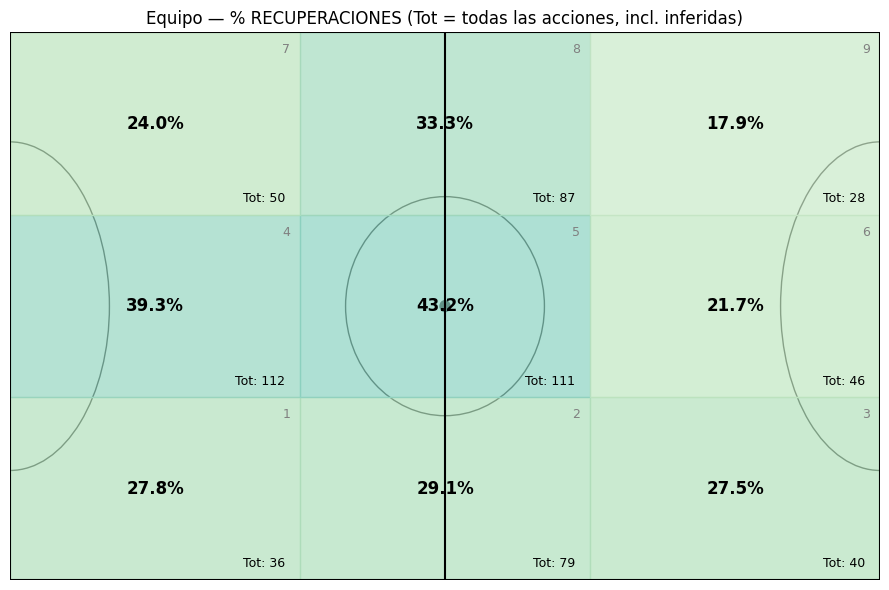

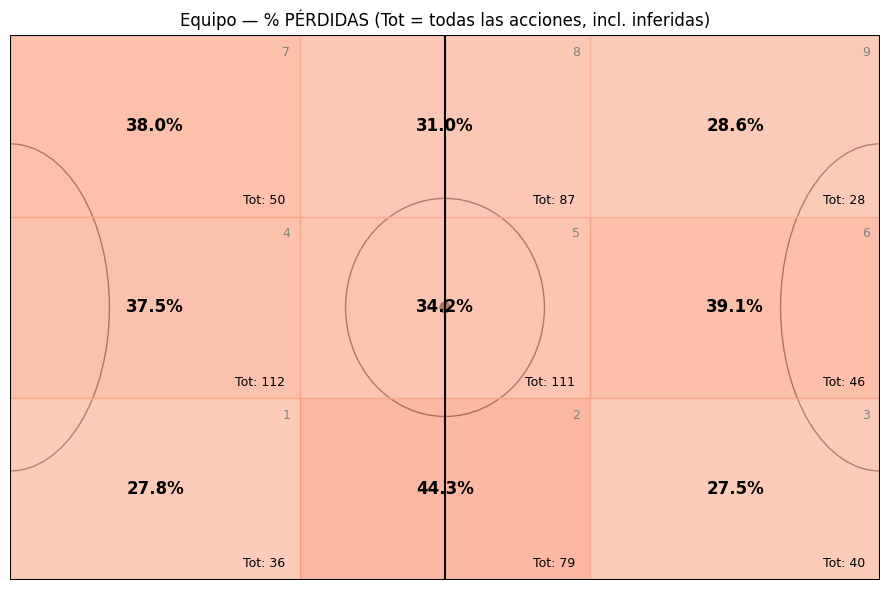

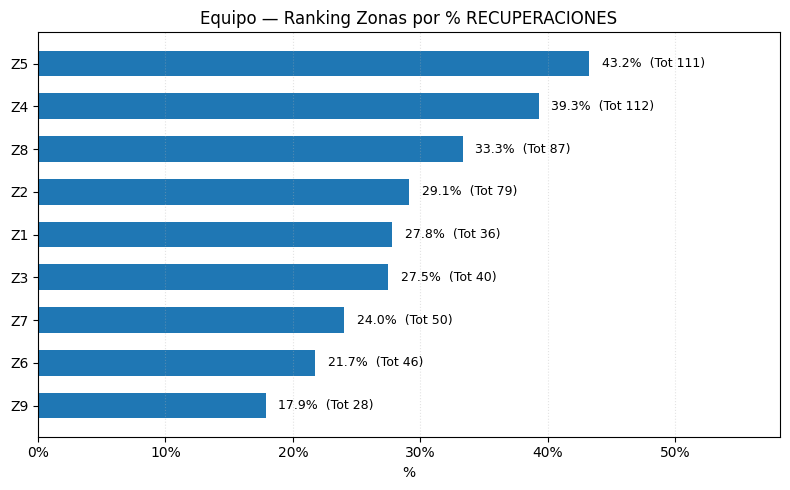

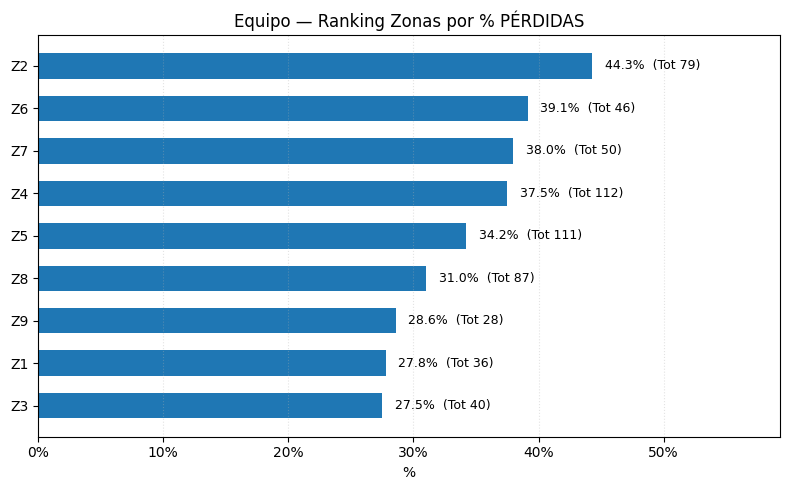

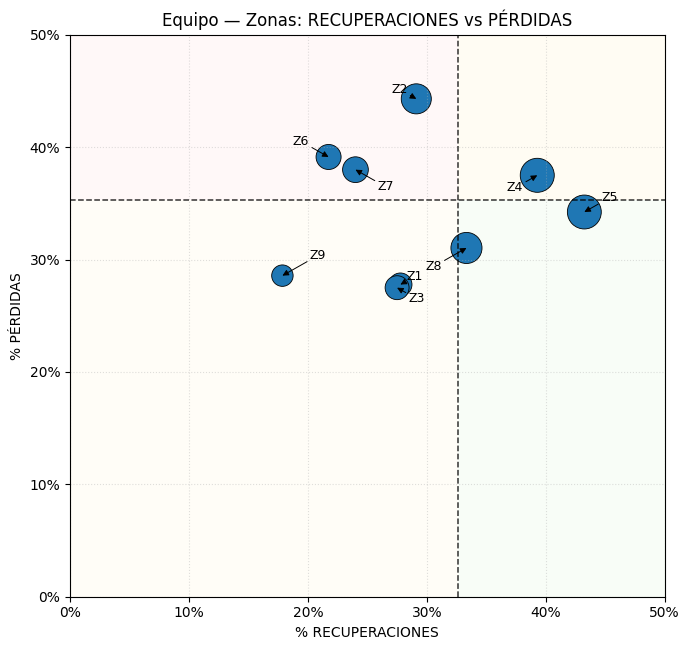

In [8]:
# =========================
# VISUALES — EQUIPO Y JUGADOR
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter

# --- parámetros de la cancha (de tu script) ---
ANCHO, ALTO = 35, 20
N_COLS, N_ROWS = 3, 3

# ---------- utilidades de cancha ----------
def draw_futsal_pitch_grid(ax):
    dx, dy = ANCHO / N_COLS, ALTO / N_ROWS
    ax.set_facecolor("white")
    # bordes + media
    ax.plot([0, ANCHO], [0, 0], color="black")
    ax.plot([0, ANCHO], [ALTO, ALTO], color="black")
    ax.plot([0, 0], [0, ALTO], color="black")
    ax.plot([ANCHO, ANCHO], [0, ALTO], color="black")
    ax.plot([ANCHO/2, ANCHO/2], [0, ALTO], color="black")
    # áreas y círculo central
    ax.add_patch(Arc((0, ALTO/2), 8, 12, angle=0, theta1=270, theta2=90, color="black"))
    ax.add_patch(Arc((ANCHO, ALTO/2), 8, 12, angle=0, theta1=90, theta2=270, color="black"))
    ax.add_patch(plt.Circle((ANCHO/2, ALTO/2), 4, color="black", fill=False))
    ax.add_patch(plt.Circle((ANCHO/2, ALTO/2), 0.2, color="black"))
    # grilla + numeración
    for j in range(N_ROWS):
        for i in range(N_COLS):
            x0, y0 = i * dx, j * dy
            ax.add_patch(Rectangle((x0, y0), dx, dy, linewidth=0.6, edgecolor='gray', facecolor='none'))
            zona = j * N_COLS + i + 1
            ax.text(x0 + dx - 0.4, y0 + dy - 0.4, str(zona), ha='right', va='top', fontsize=9, color='gray')
    ax.set_xlim(0, ANCHO); ax.set_ylim(0, ALTO); ax.axis('off')

# ---------- helpers matrices ↔︎ DF ----------
def mat_from_resumen(df, col):
    M = np.zeros((N_ROWS, N_COLS), dtype=float)
    for _, r in df.iterrows():
        M[int(r["row"]), int(r["col"])] = float(r[col])
    return M

def bars_sorted(df, col_pct):
    d = (df[["zona", col_pct, "total_acciones"]]
         .rename(columns={col_pct:"pct"})).copy()
    d["zona_lbl"] = d["zona"].apply(lambda z: f"Z{int(z)}")
    d = d.sort_values("pct", ascending=False).reset_index(drop=True)
    return d

def _fmt_pct01(x, pos):  # 0–1 → 0–100%
    return f"{x*100:.0f}%"

# ---------- mapa de calor genérico ----------
def plot_heatmap_zonas(matriz_pct, matriz_tot, title, good_high=True):
    """
    matriz_pct: valores 0–1
    matriz_tot: totales (incluye inferidas/‘peso’)
    good_high=True pinta verde a mayor valor; False invierte (rojos)
    """
    fig, ax = plt.subplots(figsize=(9, 6))
    draw_futsal_pitch_grid(ax)

    if good_high:
        cmap = LinearSegmentedColormap.from_list("good", ["#f0f9e8","#bae4bc","#7bccc4","#2b8cbe","#08589e"])
    else:
        cmap = LinearSegmentedColormap.from_list("bad",  ["#fff5f0","#fcbba1","#fc9272","#ef3b2c","#99000d"])

    dx, dy = ANCHO / N_COLS, ALTO / N_ROWS
    for j in range(N_ROWS):
        for i in range(N_COLS):
            v = float(matriz_pct[j, i])
            tot = float(matriz_tot[j, i])
            color = cmap(v) if tot > 0 else (0.95, 0.95, 0.95, 1.0)
            ax.add_patch(Rectangle((i*dx, j*dy), dx, dy, color=color, alpha=0.7))
            # % centrado
            if tot > 0:
                ax.text(i*dx + dx/2, j*dy + dy/2, f"{v*100:.1f}%", fontsize=12,
                        ha='center', va='center', color='black', fontweight='bold')
            else:
                ax.text(i*dx + dx/2, j*dy + dy/2, "", ha='center', va='center')
            # Tot: N abajo-derecha (entero redondeado por presentación)
            ax.text(i*dx + dx - 0.6, j*dy + 0.35, f"Tot: {int(round(tot))}",
                    fontsize=9, ha='right', va='bottom', color='black')
    plt.title(title); plt.tight_layout(); plt.show()

# ---------- barras por zonas ----------
def plot_barras_por_zona(df, col_pct, titulo):
    d = bars_sorted(df, col_pct)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.barh(d["zona_lbl"], d["pct"], height=0.6)
    ax.invert_yaxis()
    ax.xaxis.set_major_formatter(FuncFormatter(_fmt_pct01))
    ax.set_xlabel("%"); ax.set_title(titulo)
    for y, (v, t) in enumerate(zip(d["pct"], d["total_acciones"])):
        ax.text(v + 0.01, y, f"{v*100:.1f}%  (Tot {int(round(t))})", va="center", fontsize=9)
    ax.set_xlim(0, max(0.01, d["pct"].max()) + 0.15)
    ax.grid(axis="x", linestyle=":", alpha=0.35)
    plt.tight_layout(); plt.show()

# ---------- scatter zonas (X=recu, Y=perd) con burbujas ~ Tot, medias y cuadrantes ----------
def plot_scatter_recu_perd(df, titulo, weighted=True):
    """
    Espera en df (equipo o jugador) las columnas:
      - '%_recuperaciones_sobre_total'
      - '%_perdidas_sobre_total'
      - 'total_acciones'
      - 'zona'
    Burbuja ~ total_acciones, líneas de promedio (ponderadas si weighted=True),
    cuadrantes coloreados (verde = mejor: +recu / -perd).
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter
    from matplotlib.patches import Rectangle

    # --- columnas base ---
    x = df["%_recuperaciones_sobre_total"].astype(float).to_numpy()
    y = df["%_perdidas_sobre_total"].astype(float).to_numpy()
    zonas = df["zona"].astype(int).to_numpy()
    tots = df.get("total_acciones", pd.Series([1]*len(df))).astype(float).to_numpy()

    # --- tamaño de burbuja (suave y legible) ---
    tmax = max(1.0, tots.max())
    sizes = 60 + 540 * (tots / tmax) ** 0.8   # 60–600 aprox

    # --- promedios (ponderados o simples) ---
    if weighted and np.isfinite(tots).all() and tots.sum() > 0:
        mx = np.average(x, weights=tots)
        my = np.average(y, weights=tots)
    else:
        mx = np.nanmean(x); my = np.nanmean(y)

    # --- límites y ticks 0%,10%,..., tope cercano a máximo ---
    def _ceil_to_10pct(u):
        # sube al múltiplo de 10% más cercano pero < 100%
        val = min(1.0, (np.ceil(u*100/10)*10)/100)
        return max(0.1, val)  # al menos 10% para que haya rejilla
    xmax = _ceil_to_10pct(max(0.01, x.max()*1.05))
    ymax = _ceil_to_10pct(max(0.01, y.max()*1.05))
    xticks = np.linspace(0, xmax, int(round(xmax*10))+1)  # cada 10%
    yticks = np.linspace(0, ymax, int(round(ymax*10))+1)

    # --- figura ---
    fig, ax = plt.subplots(figsize=(7, 6.6))

    # --- fondo por cuadrantes (verde=mejor, rojo=peor) ---
    # cuadrantes: (x mx) × (y my)
    # verde: x≥mx & y≤my | rojo: x≤mx & y≥my | amarillos: los otros dos
    alpha = 0.12
    # abajo-izq (peor recu, mejor perd) -> amarillo claro
    ax.add_patch(Rectangle((0, 0), mx, my, facecolor="#fff3bf", edgecolor="none", alpha=alpha))
    # abajo-der (mejor, +recu / -perd) -> verde
    ax.add_patch(Rectangle((mx, 0), xmax-mx, my, facecolor="#c6f5c1", edgecolor="none", alpha=alpha))
    # arriba-izq (peor, -recu / +perd) -> rojo
    ax.add_patch(Rectangle((0, my), mx, ymax-my, facecolor="#ffcccc", edgecolor="none", alpha=alpha))
    # arriba-der (intermedio) -> amarillo suave
    ax.add_patch(Rectangle((mx, my), xmax-mx, ymax-my, facecolor="#ffe8a1", edgecolor="none", alpha=alpha))

    # --- nube de puntos ---
    sc = ax.scatter(x, y, s=sizes, edgecolor="k", linewidth=0.6)

    # --- etiquetas con flechita (para evitar superposición directa) ---
    # offsets alternados y flechita corta hacia la burbuja
    offsets = np.linspace(0.012, 0.03, len(zonas))
    for i, (xi, yi, zi, off) in enumerate(zip(x, y, zonas, offsets)):
        # alterno lados para despegar
        dx = off if i % 2 == 0 else -off
        dy = off * (0.6 if (i//2) % 2 == 0 else -0.6)
        ax.annotate(f"Z{zi}",
                    xy=(xi, yi),
                    xytext=(xi + dx, yi + dy),
                    textcoords="data",
                    ha="center", va="center", fontsize=9,
                    arrowprops=dict(arrowstyle="-|>", lw=0.7, color="black", shrinkA=0, shrinkB=0))

    # --- líneas de promedio ---
    ax.axvline(mx, color="black", lw=1.1, ls="--", alpha=0.8)
    ax.axhline(my, color="black", lw=1.1, ls="--", alpha=0.8)
    #ax.text(mx, ymax, "  media RECUP.", fontsize=9, va="top", ha="left")
    #ax.text(xmax, my, "media PÉRD.  ", fontsize=9, va="bottom", ha="right")

    # --- ejes, formato % y rejilla ---
    ax.set_xlim(0, xmax); ax.set_ylim(0, ymax)
    ax.set_xticks(xticks); ax.set_yticks(yticks)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v*100:.0f}%"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v*100:.0f}%"))
    ax.grid(True, linestyle=":", alpha=0.4)
    ax.set_xlabel("% RECUPERACIONES"); ax.set_ylabel("% PÉRDIDAS")
    ax.set_title(titulo)

    # --- leyenda mínima de tamaño (3 referencias) ---
    #for ref in np.linspace(0.3, 1.0, 3):
    #    ax.scatter([], [], s=60 + 540*(ref**0.8), edgecolors="k", facecolors="none",
    #               label=f"Tot≈{int(round(ref*tmax))}")
    #leg = ax.legend(title="Tamaño burbuja", frameon=True, fontsize=8, loc="upper left")
    #leg.get_frame().set_alpha(0.9)

    plt.tight_layout(); plt.show()




# ====================================================
#   1) EQUIPO  (usa df_resumen_zona ya calculado)
# ====================================================
def visuals_equipo(df_resumen_zona):
    # matrices para mapas
    M_tot = mat_from_resumen(df_resumen_zona, "total_acciones")
    M_perd = mat_from_resumen(df_resumen_zona, "%_perdidas_sobre_total")
    M_recu = mat_from_resumen(df_resumen_zona, "%_recuperaciones_sobre_total")

    # mapas
    plot_heatmap_zonas(M_recu, M_tot, "Equipo — % RECUPERACIONES (Tot = todas las acciones, incl. inferidas)", good_high=True)
    plot_heatmap_zonas(M_perd, M_tot, "Equipo — % PÉRDIDAS (Tot = todas las acciones, incl. inferidas)", good_high=False)

    # barras
    plot_barras_por_zona(df_resumen_zona, "%_recuperaciones_sobre_total", "Equipo — Ranking Zonas por % RECUPERACIONES")
    plot_barras_por_zona(df_resumen_zona, "%_perdidas_sobre_total",       "Equipo — Ranking Zonas por % PÉRDIDAS")

    # scatter
    plot_scatter_recu_perd(df_resumen_zona, "Equipo — Zonas: RECUPERACIONES vs PÉRDIDAS")


# ====================================================
#   2) JUGADOR (elige nombre; solo minutos en cancha)
#       - porcentajes sobre SUS acciones
#       - Tot = sus acciones (incl. inferidas/peso)
# ====================================================
def _intervalos_jugador(df_pres, nombre):
    sel = df_pres[df_pres["nombre"].astype(str).str.contains(nombre, case=False, na=False)]
    return list(zip(sel["start_s"].astype(float), sel["end_s"].astype(float)))

def _en_minutos_del_jugador(t, intervalos):
    if pd.isna(t) or not intervalos: return False
    return any(s <= t < e for s, e in intervalos)

def resumen_por_jugador_sus_zonas(df_reg_ext, df_pres, nombre):
    """
    Devuelve DF por zona con:
      - jugador_acciones (Tot), jugador_perdidas, jugador_recuperaciones
      - %_perdidas_sobre_acc_jugador, %_recuperaciones_sobre_acc_jugador
      - row, col, zona
    Solo considera instancias en minutos del jugador.
    """
    inter = _intervalos_jugador(df_pres, nombre)
    on = df_reg_ext["t0"].apply(lambda t: _en_minutos_del_jugador(t, inter))
    d = df_reg_ext[on].copy()

    # quedarnos con las filas del jugador (match por substring)
    mask_j = d["jugador"].astype(str).str.contains(nombre, case=False, na=False)
    d = d[mask_j].copy()

    # agregar "peso" por tipo
    piv = (d.groupby(["zona","row","col","tipo"], as_index=False)
             .agg(peso=("peso","sum"))
             .pivot(index=["zona","row","col"], columns="tipo", values="peso")
             .fillna(0.0)
             .reset_index())

    for col in ["PÉRDIDA","RECUPERACIÓN","RECUPERACIÓN_INDIRECTA","OTROS"]:
        if col not in piv.columns: piv[col] = 0.0

    piv["jugador_perdidas"]       = piv["PÉRDIDA"].astype(float)
    piv["jugador_recuperaciones"] = (piv["RECUPERACIÓN"] + piv["RECUPERACIÓN_INDIRECTA"]).astype(float)
    piv["jugador_acciones"]       = (piv["PÉRDIDA"] + piv["RECUPERACIÓN"] + piv["RECUPERACIÓN_INDIRECTA"] + piv["OTROS"]).astype(float)

    piv["%_perdidas_sobre_acc_jugador"] = np.where(piv["jugador_acciones"]>0, piv["jugador_perdidas"]/piv["jugador_acciones"], 0.0)
    piv["%_recuperaciones_sobre_acc_jugador"] = np.where(piv["jugador_acciones"]>0, piv["jugador_recuperaciones"]/piv["jugador_acciones"], 0.0)

    # formateo compatible con funciones de plotting
    out = piv[["zona","row","col",
               "jugador_acciones",
               "%_perdidas_sobre_acc_jugador",
               "%_recuperaciones_sobre_acc_jugador"]].copy()

    out = out.rename(columns={
        "jugador_acciones":"total_acciones",
        "%_perdidas_sobre_acc_jugador":"%_perdidas",
        "%_recuperaciones_sobre_acc_jugador":"%_recuperaciones"
    }).sort_values("zona").reset_index(drop=True)

    return out

def visuals_jugador(df_reg_ext, df_pres, nombre):
    dfj = resumen_por_jugador_sus_zonas(df_reg_ext, df_pres, nombre)

    # matrices (sobre SUS acciones)
    M_tot = mat_from_resumen(dfj.rename(columns={"total_acciones":"total_acciones"}), "total_acciones")
    M_perd = mat_from_resumen(dfj.rename(columns={"%_perdidas":"%_perdidas"}), "%_perdidas")
    M_recu = mat_from_resumen(dfj.rename(columns={"%_recuperaciones":"%_recuperaciones"}), "%_recuperaciones")

    # mapas
    plot_heatmap_zonas(M_recu, M_tot, f"{nombre} — % RECUPERACIONES (sobre SUS acciones)", good_high=True)
    plot_heatmap_zonas(M_perd, M_tot, f"{nombre} — % PÉRDIDAS (sobre SUS acciones)",       good_high=False)

    # barras (ordenadas)
    d_recu = dfj.rename(columns={"%_recuperaciones":"%_recuperaciones_sobre_total"})  # reuso de función
    d_perd = dfj.rename(columns={"%_perdidas":"%_perdidas_sobre_total"})
    plot_barras_por_zona(d_recu, "%_recuperaciones_sobre_total", f"{nombre} — Ranking Zonas por % RECUPERACIONES (sus acciones)")
    plot_barras_por_zona(d_perd, "%_perdidas_sobre_total",       f"{nombre} — Ranking Zonas por % PÉRDIDAS (sus acciones)")

    # scatter (X=recu, Y=perd) con ticks 0–100%
    d_sc = dfj.copy()
    d_sc = d_sc.rename(columns={
        "%_recuperaciones":"%_recuperaciones_sobre_total",
        "%_perdidas":"%_perdidas_sobre_total"
    })
    plot_scatter_recu_perd(d_sc, f"{nombre} — Zonas: RECUPERACIONES vs PÉRDIDAS (sus acciones)")

# ======================
# USO
# ======================
# 1) Equipo
visuals_equipo(df_resumen_zona)



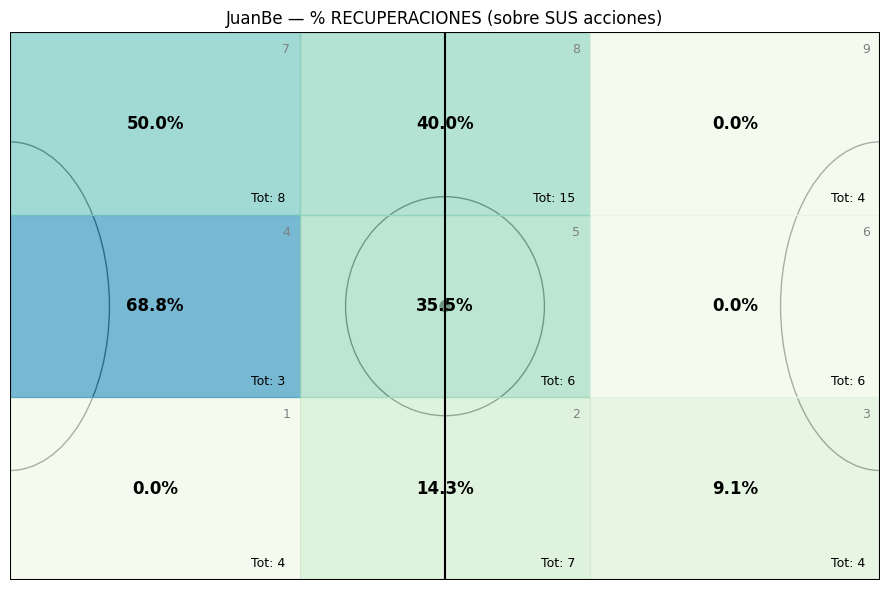

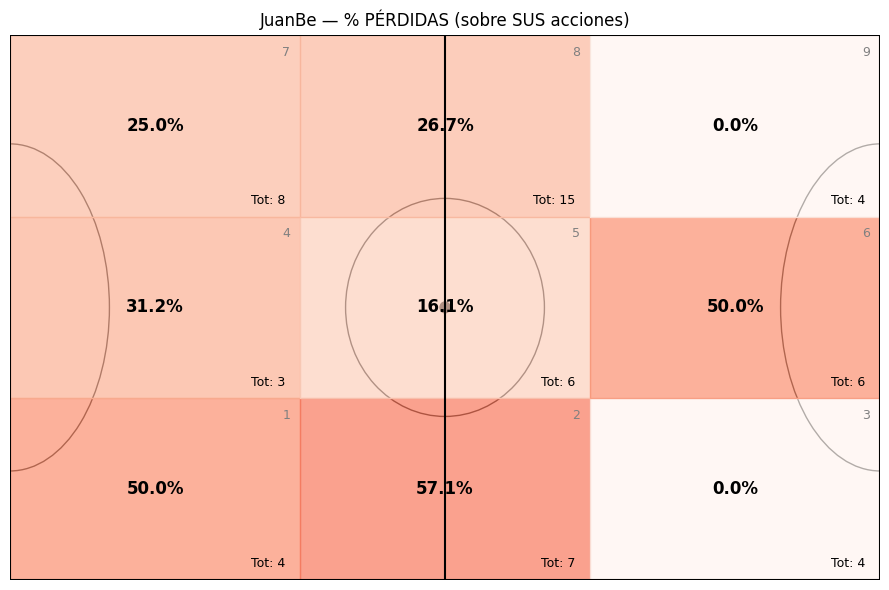

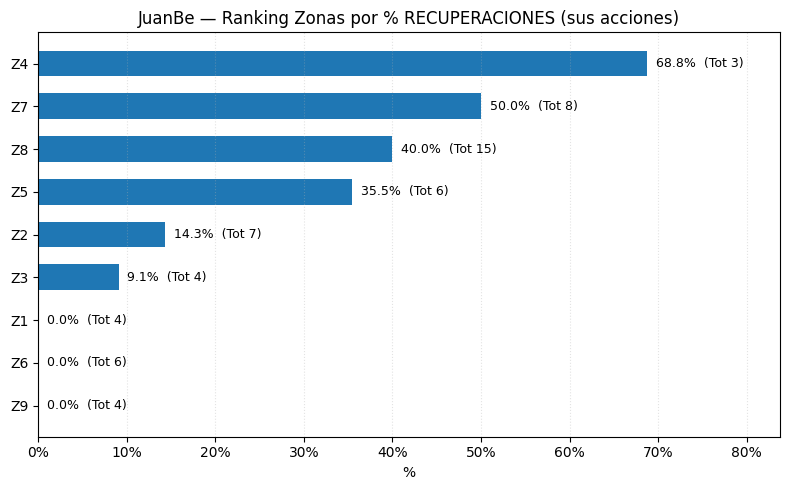

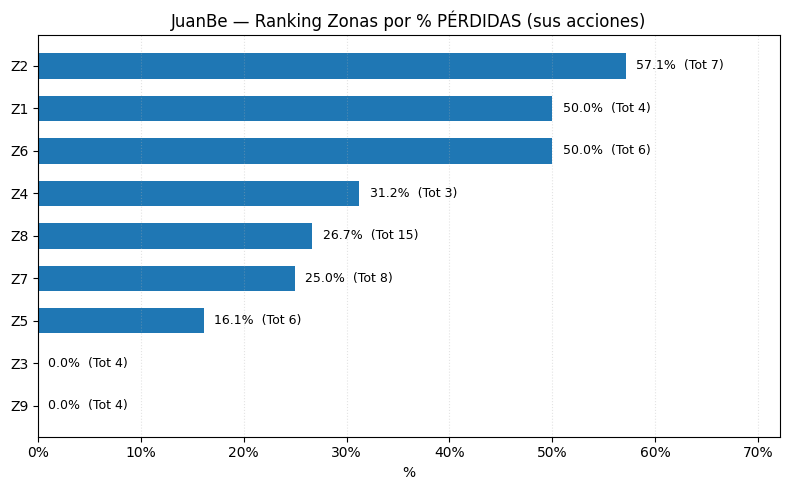

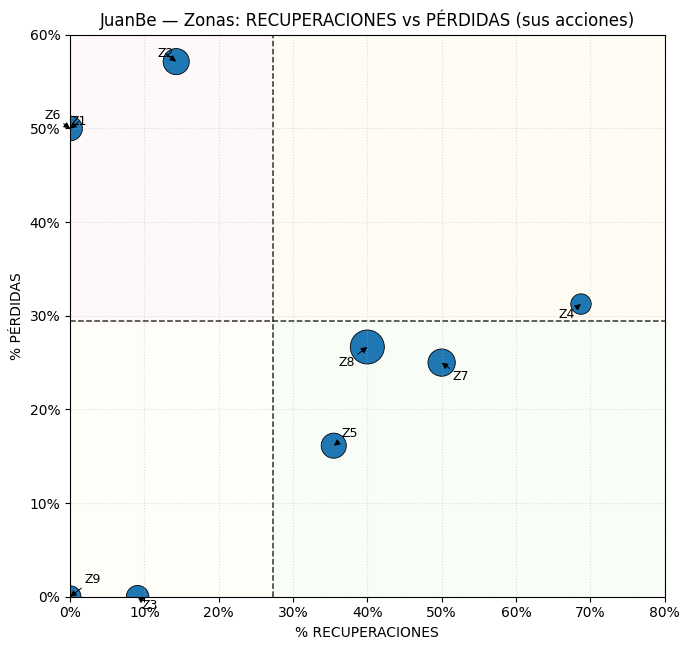

In [10]:
# 2) Jugador (cambiá el nombre a gusto)
JUGADOR = "JuanBe"
visuals_jugador(df_registros_ext, df_pres, JUGADOR)